# to do
 - add individual uncertainty to GPR fitting
 - https://scikit-learn.org/stable/auto_examples/gaussian_process/plot_gpr_noisy_targets.html

In [72]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt


import numpy as np

In [73]:
matplotlib.rcParams.update({'font.size': 16})

In [74]:
import pickle

# freq_parts = [PSF_freq_ins, PSF_freq_int, PSF_freq_mr]
# amp_parts = [PSF_amp_ins, PSF_amp_int, PSF_amp_mr]

# for part in freq_parts:
#     # Serialize data into file:
#     data = part.ready_to_fit
#     part_name = part.name
#     name = "freq_{}.p".format(part_name)
#     pickle.dump(data, open(name, "wb"))

# for part in amp_parts:
#     # Serialize data into file:
#     data = part.ready_to_fit
#     part_name = part.name
#     name = "amp_{}.p".format(part_name)
#     pickle.dump(data, open(name, "wb"))


import glob
files = glob.glob("*.p")
data = {}
for f in files:
    data.update({f.split('.p')[0]:pickle.load(open(f, 'rb'))})


In [75]:
data['amp_mr']['x']

{'eta': array([0.25      , 0.22222234, 0.1600003 , 0.13888911, 0.08264502,
        0.04986614]), 'q': array([ 1.,  2.,  4.,  5., 10., 18.])}

In [76]:
data['amp_mr']['y']

{'A0': array([0.18904992, 0.14779117, 0.07371353, 0.05478144, 0.01905553,
        0.00695755]),
 'a1': array([-1.82399962, -1.79676276, -1.71113521, -1.71521413, -1.62653066,
        -1.62570241]),
 'a2': array([1.78215357, 1.62447851, 1.30336812, 1.25560639, 0.93664514,
        0.81997418]),
 't0': array([7.64379681, 7.63831001, 7.71115149, 8.27840657, 8.39782226,
        9.00415383]),
 'kappa': array([0.13874635, 0.13589445, 0.12628318, 0.11970278, 0.1117015 ,
        0.09936851])}

<ErrorbarContainer object of 3 artists>

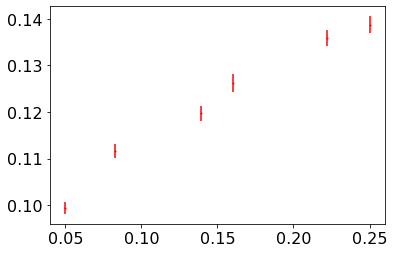

In [77]:
plt.figure()
# plt.scatter(data['amp_mr']['x']['eta'], data['amp_mr']['y']['kappa'])

plt.errorbar(
    data['amp_mr']['x']['eta'],
    data['amp_mr']['y']['kappa'],
    yerr=data['amp_mr']['stderr']['kappa'],
    fmt='r.',
    markersize=2
)


# Polynomial

In [78]:
import lmfit
from lmfit import Minimizer, Parameters, report_fit

class ParSpaceFits(object):
    def __init__(self, data):
        """
        data = e.g. data['amp_mr']
        """
        
        self.data = data
        self.q = self.data['x']['q']
        self.eta = self.data['x']['eta']
        
        
        self.results = {}
        self.ynames = list(self.data['y'].keys())
        
        for k in self.ynames:
            
            q = self.q
            eta = self.eta
#             self.results.update({k:{"name":{}, 'q':q, 'eta':eta}})
            self.results.update({k:{"name":{}, 'q':q, 'eta':eta}})

            
            for pk in self.ynames:
                v = self.data['y'][pk]
                self.results[k]["name"].update({pk:v})
            
        self.build_arrays()
        
        self.par_space_result = {}
        for k in self.ynames:
            print(k)
            self.par_space_result.update({k:self.fit(yname=k, xname='eta')})
        
        
    def build_arrays(self):
        
        self.ready_to_fit = {'x':{}, 'y':{}}
        
        
        for parname in self.ynames:
            array_eta = self.data['x']['eta']
            array_q = self.data['x']['q']
            array_y = self.data['y'][parname]

            self.ready_to_fit['x'].update({"eta":np.array(array_eta), "q":np.array(array_q)})
            self.ready_to_fit['y'].update({parname:np.array(array_y)})
            
            
            
    def model_evaluate(self, parname, x):
        params = self.par_space_result[parname].params
        return self.ansatz(params, x)
            
    def ansatz(self, params, x):

        a = params['a']
        b = params['b']
        c = params['c']
        d = params['d']
        e = params['e']

#         model = a + b*x + c*np.sqrt(x)
#         model = a + b*x + c*np.log(x)
#         model = a + b*x + c*x**2
#         model = a + b*x + c*x**2 + d*x**3
#         model = a + b*x + d*x**3
        model = a + b*x + c*x**2 + d*x**3 + e*x**4

        return model

    def ansatz_to_min(self, params, x, y):
        model = self.ansatz(params, x)
        return model - y

    def fit(self, yname, xname='eta'):
        
        
        fit_x = self.ready_to_fit['x'][xname]
        fit_y = self.ready_to_fit['y'][yname]
    
    
        # sort them by first column i.e. mass-raito or eta
        fit_xy = np.array([fit_x, fit_y]).T
        tmp = sorted(fit_xy, key=lambda x: x[0])
        tmp = np.array(tmp).T
        self.fit_x, self.fit_y = tmp[0], tmp[1]

        # create a set of Parameters
        params = Parameters()

        params.add('a', value=10., min=-20000, max=50000)
        params.add('b', value=300., min=-20000, max=20000)
        params.add('c', value=400., min=-40000, max=10000)
        params.add('d', value=300., min=-40000, max=40000)
        params.add('e', value=300., min=-40000, max=40000)

        fcn2min = self.ansatz_to_min
        minner = Minimizer(fcn2min, params, fcn_args=(self.fit_x, self.fit_y))

        result = minner.minimize()

        # calculate final result
        final = self.fit_y + result.residual

        # write error report
        report_fit(result)
        return result


In [79]:
PSFs = {}
for k in data.keys():
    PSFs.update({k:ParSpaceFits(data[k])})

A0
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 19
    # data points      = 6
    # variables        = 5
    chi-square         = 2.6617e-10
    reduced chi-square = 2.6617e-10
    Akaike info crit   = -133.031925
    Bayesian info crit = -134.073128
[[Variables]]
    a: -0.00287278 +/- 1.8434e-04 (6.42%) (init = 10)
    b:  0.12987654 +/- 0.00639549 (4.92%) (init = 300)
    c:  0.83482569 +/- 0.07383535 (8.84%) (init = 400)
    d:  11.1537066 +/- 0.34907167 (3.13%) (init = 300)
    e: -17.1516240 +/- 0.58069660 (3.39%) (init = 300)
[[Correlations]] (unreported correlations are < 0.100)
    C(d, e) = -0.994
    C(c, d) = -0.992
    C(b, c) = -0.991
    C(a, b) = -0.989
    C(c, e) =  0.973
    C(b, d) =  0.967
    C(a, c) =  0.963
    C(b, e) = -0.935
    C(a, d) = -0.926
    C(a, e) =  0.885
a1
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 19
    # data points      = 6
    # variables        = 5
    chi-square         = 5.

In [80]:
PSFs['amp_mr'].model_evaluate('A0', 0.25)

0.18905109701762512

# GPR

In [81]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C

np.random.seed(1)

In [82]:
def fit_and_plot_gpr(name, data, PSF=None):
    """
    name = ['amp_mr']
    data = e.g data dict
    PSF = parameter space fits 
    """
    data = data[name]
    PSF = PSF[name]
    
    ys = list(data['y'].keys())
    
    for yname in ys:
        
        X = data['x']['eta'].reshape((6,1))
        y = data['y'][yname]
        
        dy = data['stderr'][yname]
        
        # Instantiate a Gaussian Process model
        kernel = C(1.0, (1e-7, 1e7)) * RBF(10, (1e-4, 1e4))

#         
#         gp = GaussianProcessRegressor(kernel=kernel,
#                                       n_restarts_optimizer=100
#                                      )

#         gp = GaussianProcessRegressor(kernel=kernel,
#                                       n_restarts_optimizer=100,
#                                       alpha=dy**2, normalize_y=True
#                                      )
        gp = GaussianProcessRegressor(kernel=kernel,
                                      n_restarts_optimizer=100,
                                      alpha=dy**2, normalize_y=False
                                     )

        # Fit to data using Maximum Likelihood Estimation of the parameters
        gp.fit(X, y)

        x = np.linspace(0,0.25,100).reshape((100,1))

        # Make the prediction on the meshed x-axis (ask for MSE as well)
        y_pred, sigma = gp.predict(x, return_std=True)
        
        # Plot the function, the prediction and the 95% confidence interval based on
        # the MSE
        plt.figure(figsize=(10,6))
#         plt.plot(X, y, 'r.', markersize=10, label='Observations')
        plt.plot(x, y_pred, 'b-', label='Prediction')
        plt.fill(np.concatenate([x, x[::-1]]),
                 np.concatenate([y_pred - 1.9600 * sigma,
                                (y_pred + 1.9600 * sigma)[::-1]]),
                 alpha=.5, fc='b', ec='None', label='95% confidence interval')
        plt.xlabel('$\eta$')
        plt.ylabel('{}'.format(yname))
        # plt.ylim(-10, 20)
        
        plt.errorbar(X.ravel(), y, dy, fmt='r.', markersize=10, label='Observations')
        
        if PSF:
            PSFy = PSF.model_evaluate(yname, x)
            plt.plot(x, PSFy, label='polynomial', lw=3, ls='--')
        
        plt.legend(loc='best')
        plt.show()
        plt.close()
        
        print("gp kernel params")
        print(gp.kernel_.get_params())
        
        

        outname = "{}-{}.pkl".format(name, yname)
        print("saving gp model to: {}".format(outname))
        with open(outname,'wb') as f:
            pickle.dump(gp,f)

====

working: amp_mr

====



/Users/spx8sk/anaconda3/envs/wispy-dev/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([16.        ,  4.16795399]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 21, 'nit': 0, 'warnflag': 2}
  ConvergenceWarning)


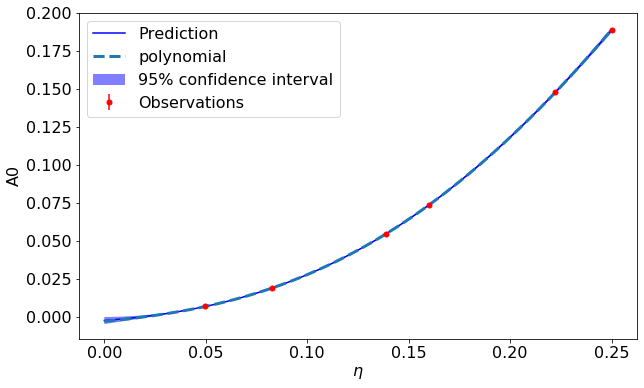

gp kernel params
{'k1': 0.357**2, 'k2': RBF(length_scale=0.31), 'k1__constant_value': 0.12740897176949853, 'k1__constant_value_bounds': (1e-07, 10000000.0), 'k2__length_scale': 0.31049210368888275, 'k2__length_scale_bounds': (0.0001, 10000.0)}
saving gp model to: amp_mr-A0.pkl


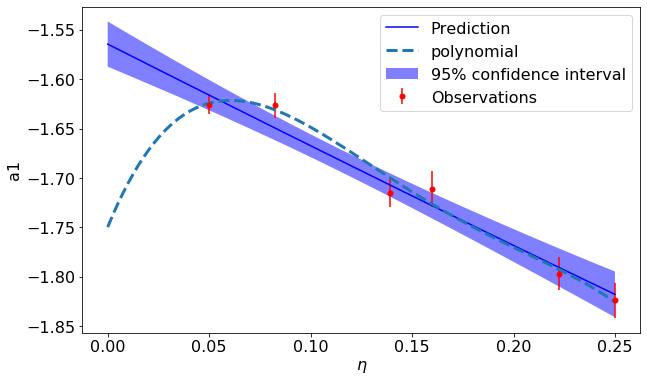

gp kernel params
{'k1': 1.99**2, 'k2': RBF(length_scale=2.19), 'k1__constant_value': 3.9541018671647437, 'k1__constant_value_bounds': (1e-07, 10000000.0), 'k2__length_scale': 2.188035298540886, 'k2__length_scale_bounds': (0.0001, 10000.0)}
saving gp model to: amp_mr-a1.pkl


gp kernel params
{'k1': 2.2**2, 'k2': RBF(length_scale=0.621), 'k1__constant_value': 4.831817200045479, 'k1__constant_value_bounds': (1e-07, 10000000.0), 'k2__length_scale': 0.620729432648844, 'k2__length_scale_bounds': (0.0001, 10000.0)}
saving gp model to: amp_mr-a2.pkl


/Users/spx8sk/anaconda3/envs/wispy-dev/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-9.06996138e-06,  1.98599984e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 55, 'nit': 10, 'warnflag': 2}
  ConvergenceWarning)


gp kernel params
{'k1': 6.69**2, 'k2': RBF(length_scale=0.0699), 'k1__constant_value': 44.764341728561, 'k1__constant_value_bounds': (1e-07, 10000000.0), 'k2__length_scale': 0.0698715995823897, 'k2__length_scale_bounds': (0.0001, 10000.0)}
saving gp model to: amp_mr-t0.pkl


gp kernel params
{'k1': 0.104**2, 'k2': RBF(length_scale=0.521), 'k1__constant_value': 0.010836914598917243, 'k1__constant_value_bounds': (1e-07, 10000000.0), 'k2__length_scale': 0.5213399683695332, 'k2__length_scale_bounds': (0.0001, 10000.0)}
saving gp model to: amp_mr-kappa.pkl
====

working: freq_mr

====



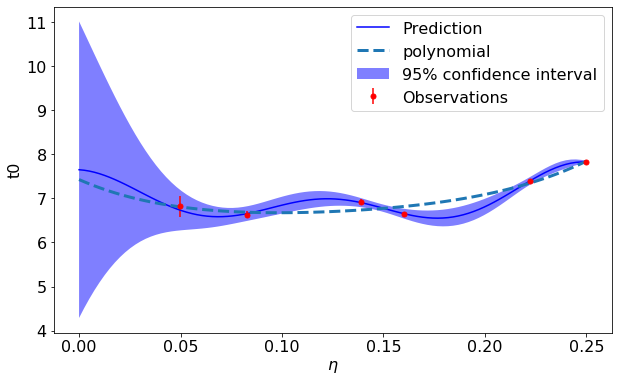

gp kernel params
{'k1': 5.65**2, 'k2': RBF(length_scale=0.0724), 'k1__constant_value': 31.93073409554806, 'k1__constant_value_bounds': (1e-07, 10000000.0), 'k2__length_scale': 0.07243610319967671, 'k2__length_scale_bounds': (0.0001, 10000.0)}
saving gp model to: freq_mr-t0.pkl


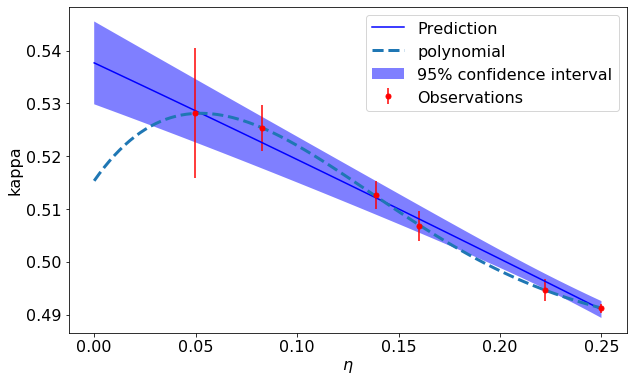

gp kernel params
{'k1': 0.541**2, 'k2': RBF(length_scale=3.02), 'k1__constant_value': 0.29226476996890843, 'k1__constant_value_bounds': (1e-07, 10000000.0), 'k2__length_scale': 3.0226676196019544, 'k2__length_scale_bounds': (0.0001, 10000.0)}
saving gp model to: freq_mr-kappa.pkl
====

working: amp_ins

====



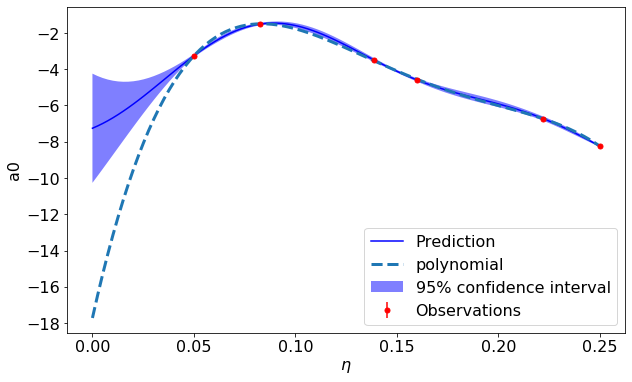

gp kernel params
{'k1': 6.55**2, 'k2': RBF(length_scale=0.0758), 'k1__constant_value': 42.88029388701711, 'k1__constant_value_bounds': (1e-07, 10000000.0), 'k2__length_scale': 0.07576562424209353, 'k2__length_scale_bounds': (0.0001, 10000.0)}
saving gp model to: amp_ins-a0.pkl


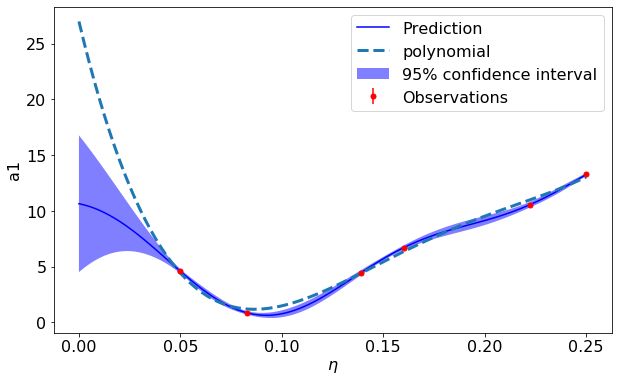

gp kernel params
{'k1': 9.96**2, 'k2': RBF(length_scale=0.0687), 'k1__constant_value': 99.27621731583456, 'k1__constant_value_bounds': (1e-07, 10000000.0), 'k2__length_scale': 0.06865891707079819, 'k2__length_scale_bounds': (0.0001, 10000.0)}
saving gp model to: amp_ins-a1.pkl
====

working: freq_int

====



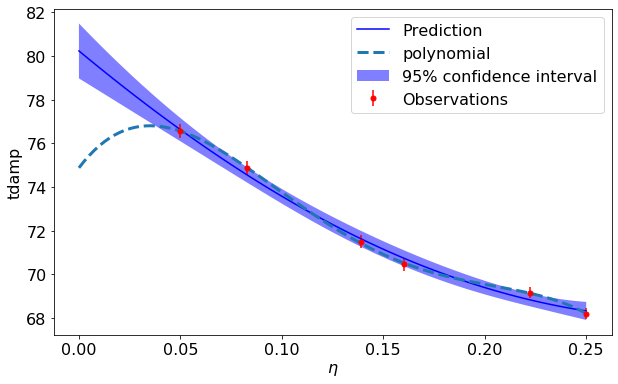

gp kernel params
{'k1': 90.5**2, 'k2': RBF(length_scale=0.674), 'k1__constant_value': 8195.70973776512, 'k1__constant_value_bounds': (1e-07, 10000000.0), 'k2__length_scale': 0.6736996211091266, 'k2__length_scale_bounds': (0.0001, 10000.0)}
saving gp model to: freq_int-tdamp.pkl


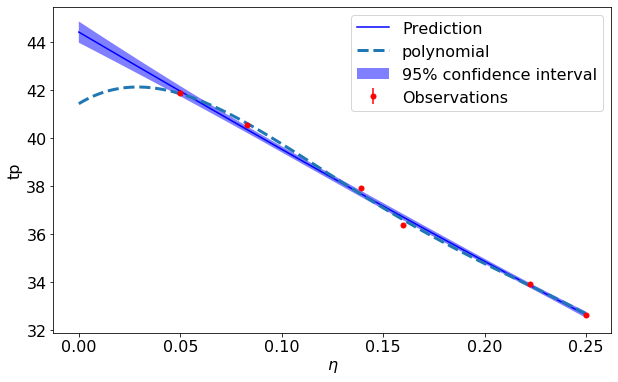

gp kernel params
{'k1': 54.8**2, 'k2': RBF(length_scale=1.31), 'k1__constant_value': 3002.5869628396817, 'k1__constant_value_bounds': (1e-07, 10000000.0), 'k2__length_scale': 1.3089753360122622, 'k2__length_scale_bounds': (0.0001, 10000.0)}
saving gp model to: freq_int-tp.pkl


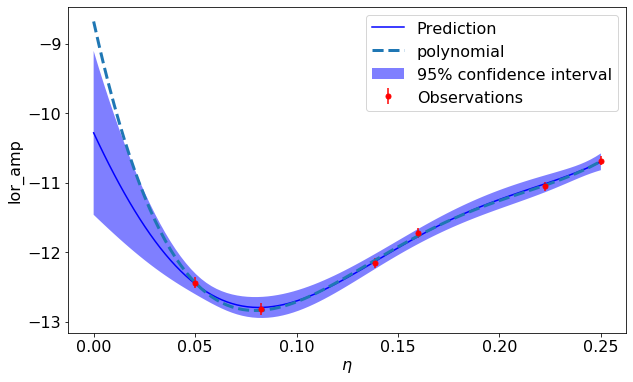

gp kernel params
{'k1': 8.01**2, 'k2': RBF(length_scale=0.14), 'k1__constant_value': 64.18046384106563, 'k1__constant_value_bounds': (1e-07, 10000000.0), 'k2__length_scale': 0.13968287762681, 'k2__length_scale_bounds': (0.0001, 10000.0)}
saving gp model to: freq_int-lor_amp.pkl


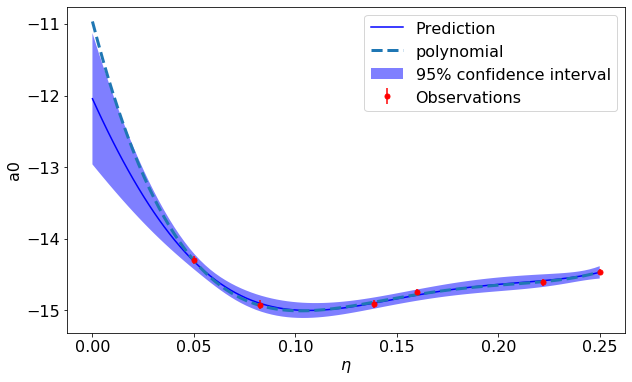

gp kernel params
{'k1': 9.88**2, 'k2': RBF(length_scale=0.16), 'k1__constant_value': 97.60043604046953, 'k1__constant_value_bounds': (1e-07, 10000000.0), 'k2__length_scale': 0.1597518017085936, 'k2__length_scale_bounds': (0.0001, 10000.0)}
saving gp model to: freq_int-a0.pkl


/Users/spx8sk/anaconda3/envs/wispy-dev/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-4.13912062e-07, -1.78575394e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 64, 'nit': 14, 'warnflag': 2}
  ConvergenceWarning)
/Users/spx8sk/anaconda3/envs/wispy-dev/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-64.        ,  -0.72586569]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 27, 'nit': 1, 'warnflag': 2}
  ConvergenceWarning)
/Users/spx8sk/anaconda3/envs/wispy-dev/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([512.        ,  -0.79986987]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 42, 'nit': 1, 'warnflag': 2}
  ConvergenceWarning)


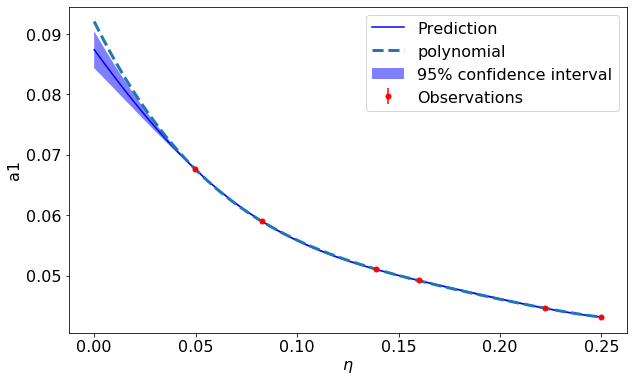

gp kernel params
{'k1': 0.0746**2, 'k2': RBF(length_scale=0.161), 'k1__constant_value': 0.005560554545412313, 'k1__constant_value_bounds': (1e-07, 10000000.0), 'k2__length_scale': 0.16119041242479365, 'k2__length_scale_bounds': (0.0001, 10000.0)}
saving gp model to: freq_int-a1.pkl
====

working: amp_int

====



gp kernel params
{'k1': 38.6**2, 'k2': RBF(length_scale=0.259), 'k1__constant_value': 1487.1078651513776, 'k1__constant_value_bounds': (1e-07, 10000000.0), 'k2__length_scale': 0.25912998177304714, 'k2__length_scale_bounds': (0.0001, 10000.0)}
saving gp model to: amp_int-tp.pkl


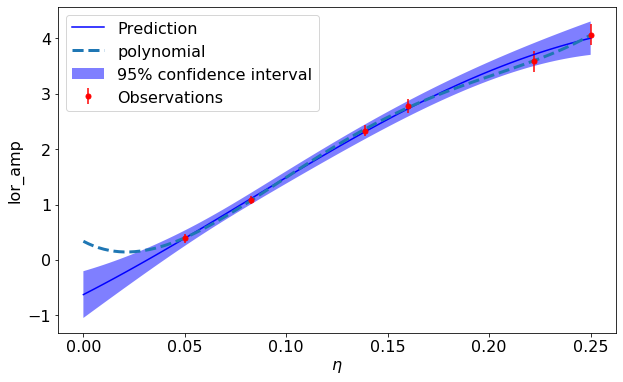

gp kernel params
{'k1': 3.25**2, 'k2': RBF(length_scale=0.247), 'k1__constant_value': 10.554156532001253, 'k1__constant_value_bounds': (1e-07, 10000000.0), 'k2__length_scale': 0.24717273247061822, 'k2__length_scale_bounds': (0.0001, 10000.0)}
saving gp model to: amp_int-lor_amp.pkl


gp kernel params
{'k1': 9.71**2, 'k2': RBF(length_scale=0.332), 'k1__constant_value': 94.36145579762042, 'k1__constant_value_bounds': (1e-07, 10000000.0), 'k2__length_scale': 0.3317620145892274, 'k2__length_scale_bounds': (0.0001, 10000.0)}
saving gp model to: amp_int-a0.pkl


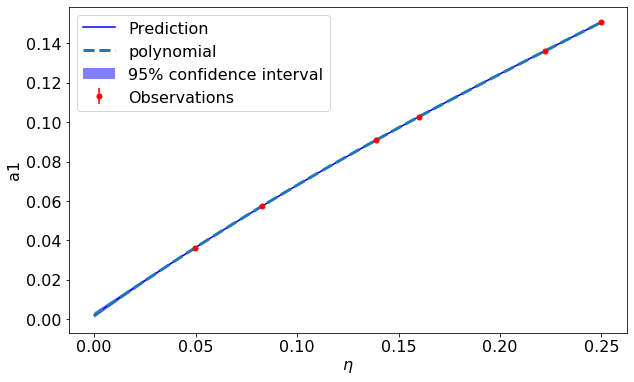

gp kernel params
{'k1': 0.26**2, 'k2': RBF(length_scale=0.418), 'k1__constant_value': 0.06752888965857437, 'k1__constant_value_bounds': (1e-07, 10000000.0), 'k2__length_scale': 0.41812389335467476, 'k2__length_scale_bounds': (0.0001, 10000.0)}
saving gp model to: amp_int-a1.pkl
====

working: freq_ins

====



/Users/spx8sk/anaconda3/envs/wispy-dev/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.        , -0.41452493]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 45, 'nit': 3, 'warnflag': 2}
  ConvergenceWarning)
/Users/spx8sk/anaconda3/envs/wispy-dev/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.        ,  0.02057045]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 58, 'nit': 9, 'warnflag': 2}
  ConvergenceWarning)
/Users/spx8sk/anaconda3/envs/wispy-dev/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-4.93505559e-06,  1.17917173e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 75, 'nit': 19, 'warnflag': 2}
  ConvergenceWarning)


gp kernel params
{'k1': 0.178**2, 'k2': RBF(length_scale=0.0761), 'k1__constant_value': 0.03175487604458858, 'k1__constant_value_bounds': (1e-07, 10000000.0), 'k2__length_scale': 0.07611233269380367, 'k2__length_scale_bounds': (0.0001, 10000.0)}
saving gp model to: freq_ins-b.pkl


/Users/spx8sk/anaconda3/envs/wispy-dev/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 0.625    , -0.0520274]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 48, 'nit': 6, 'warnflag': 2}
  ConvergenceWarning)
/Users/spx8sk/anaconda3/envs/wispy-dev/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([0.5625    , 0.25089921]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 43, 'nit': 2, 'warnflag': 2}
  ConvergenceWarning)
/Users/spx8sk/anaconda3/envs/wispy-dev/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([0.1875    , 0.36349072]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 75, 'nit': 9, 'warnflag': 2}
  ConvergenceWarning)
/Users/spx8sk/anaconda3/e

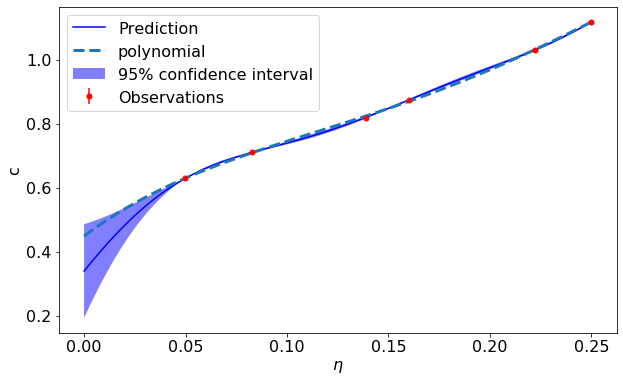

gp kernel params
{'k1': 0.799**2, 'k2': RBF(length_scale=0.097), 'k1__constant_value': 0.6388993123037892, 'k1__constant_value_bounds': (1e-07, 10000000.0), 'k2__length_scale': 0.09699542503403732, 'k2__length_scale_bounds': (0.0001, 10000.0)}
saving gp model to: freq_ins-c.pkl


In [83]:
for k in data.keys():
    print("====\n")
    print("working: {}".format(k))
    print("\n====\n")

    fit_and_plot_gpr(k, data, PSFs)

# example load

In [84]:
# with open('amp_ins-a0.pkl', 'rb') as f:
#     gp = pickle.load(f)

# gp.predict([[0.25]], return_std=True)

# del gp